In [31]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toolbox_ML as tb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import mannwhitneyu
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#import warnings library
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')

## Descripción breve del proyecto:
El proyecto consiste en construir un modelo de machine learning para predecir si un pedido de e-commerce llegará a tiempo o sufrirá un retraso. Utilizaremos un dataset que contiene variables sobre logística, atención al cliente, características del producto y condiciones de envío. La variable objetivo (target) es Reached.on.Time_Y.N, donde 1 indica entrega a tiempo y 0 indica retraso.

El tema de la logística y la entrega de productos es clave en el mundo actual del e-commerce, donde la experiencia del cliente y el cumplimiento de los tiempos son determinantes para la fidelización y satisfacción. Este proyecto me permite:

Aplicar todo el ciclo completo de Machine Learning (EDA, preprocesamiento, modelado y evaluación).

Enfrentarme a un caso de clasificación binaria realista y con impacto empresarial.

Explorar cómo variables logísticas (como el método de envío, el peso del paquete o la cantidad de llamadas al servicio al cliente) afectan la puntualidad en las entregas.

Además, este tipo de predicciones podría ayudar a las empresas a anticipar retrasos, ajustar procesos logísticos y mejorar la satisfacción del cliente final.

In [32]:
df_log= pd.read_csv("./data/Train.csv")

In [33]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


In [34]:
df_log.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

El análisis de valores nulos confirmó que no existen missing values en el dataset, por lo que no fue necesario realizar imputaciones ni eliminar registros.

In [35]:
df_log.head(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [36]:
df_log.duplicated().sum()

np.int64(0)

Tras revisar la existencia de filas duplicadas en el dataset, se confirmó que no hay registros duplicados, por lo que no fue necesario realizar eliminación de duplicados en esta fase. 

Es un dataset muy limpio

| Nombre del campo                  | Tipo de variable                                                                 |     Descripción |   ||
|-----------------------------------|----------------------------------------------------------------------------|-----------------------|----------------------|-------|
|ID	Numérica (Identificador)	|Identificador único de cada pedido.| No tiene valor predictivo, solo sirve para seguimiento.|
|Warehouse_block	|Categórica nominal|	Bloque o sección del almacén desde donde se despachó el pedido (A, B, C, D, F). No tiene orden jerárquico.|
|Mode_of_Shipment	|Categórica nominal|	Modo de envío utilizado: "Ship", "Flight", o "Road". Describe el medio de transporte.|
|Customer_care_calls|	Numérica discreta|	Número de veces que el cliente ha llamado al servicio de atención para consultar sobre el pedido.|
|Customer_rating	|Categórica ordinal|	Valoración dada por el cliente (1 a 5), donde 1 es muy mala experiencia y 5 es excelente.|
|Cost_of_the_Product	|Numérica continua	|Costo total del producto comprado. Variable monetaria.|
|Prior_purchases	|Numérica discreta|	Número de compras previas hechas por el cliente. Indica historial de compras.|
|Product_importance	|Categórica ordinal	|Nivel de importancia del producto: "low", "medium", "high". Puede influir en la prioridad de envío.|
|Gender	|Categórica binaria	|Género del cliente: "M" (masculino) o "F" (femenino).|
|Discount_offered	|Numérica continua	|Descuento ofrecido al cliente en esa compra (en valor monetario).|
|Weight_in_gms	|Numérica continua	|Peso del paquete en gramos.|
|Reached.on.Time_Y.N	|Binaria (Target)|	Variable objetivo (target). Indica si el pedido llegó a tiempo (1 = Sí, 0 = No).|

In [37]:
precent_missing = df_log.isnull().sum()*100/len(df_log)
missing_value_df = pd.DataFrame({'column_name': df_log.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_df

,column_name,percent_missing
ID,ID,0.0
Warehouse_block,Warehouse_block,0.0
Mode_of_Shipment,Mode_of_Shipment,0.0
Customer_care_calls,Customer_care_calls,0.0
Customer_rating,Customer_rating,0.0
Cost_of_the_Product,Cost_of_the_Product,0.0
Prior_purchases,Prior_purchases,0.0
Product_importance,Product_importance,0.0
Gender,Gender,0.0
Discount_offered,Discount_offered,0.0


In [38]:
target = "Reached.on.Time_Y.N"

###  Separamos train y test set

In [39]:
train_set, test_set = train_test_split(df_log, test_size = 0.2, random_state= 42)

###  MiniEDA

In [40]:
train_set["Reached.on.Time_Y.N"].value_counts(normalize=True)

Reached.on.Time_Y.N
1    0.597568
0    0.402432
Name: proportion, dtype: float64

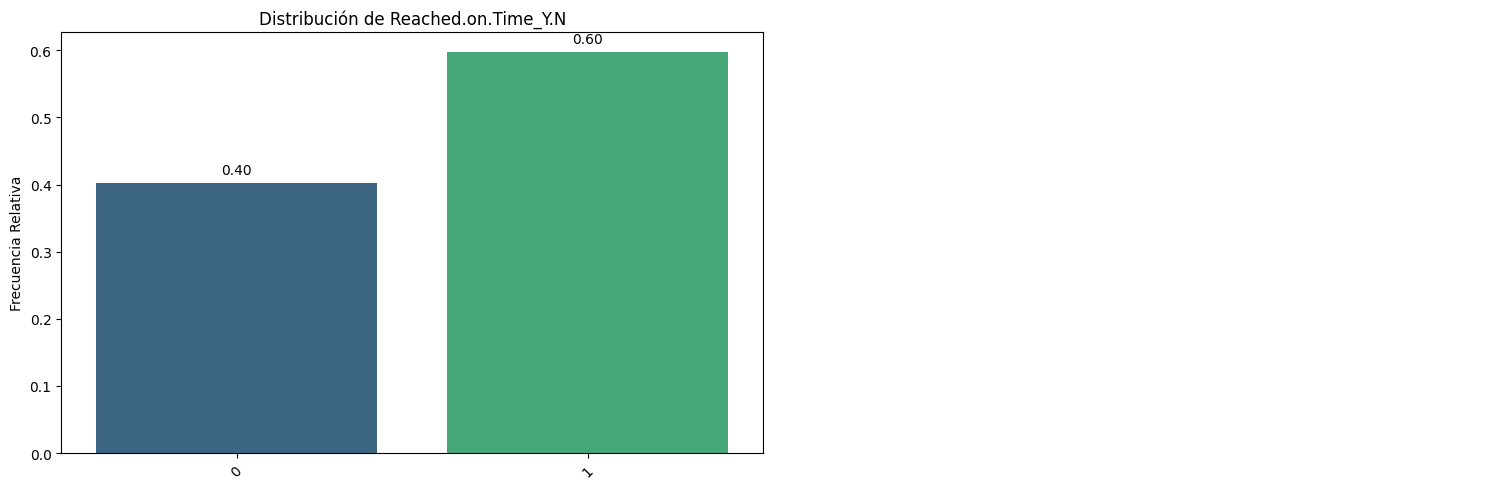

In [88]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

La distribución de la variable target muestra un problema real de desempeño logístico, y también nos indica que hay un pequeño desbalance de clases al modelar.

Hay más pedidos que llegaron tarde (casi 60%) que los que llegaron a tiempo (40%).

Esto se considera un desbalance moderado, pero  manejable.

Este desequilibrio puede afectar el desempeño de algunos modelos de clasificación (por ejemplo, modelos pueden tender a predecir más la clase mayoritaria).

Vamos a emplear el recall medio ("balanced_accuracy") en este tipo de desequilibrios es buena elección para su evaluación.

###  Clasificación y transformación de variables

En esta etapa identificaremos cuáles variables son numéricas y cuáles categóricas, ya que el tratamiento, análisis y modelado que aplicaremos a cada tipo será diferente y específico según su naturaleza.

Para este analisis aplicaremos fuciones de nuestros toolbox

Además, evaluaremos si alguna de ellas requiere transformaciones adicionales (como codificación, escalado o discretización), en función de su tipo y su distribución.

In [41]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,8799.0,5506.146380,3173.423709,2.0,2743.0,5525.0,8241.5,10999.0
Customer_care_calls,8799.0,4.058757,1.143919,2.0,3.0,4.0,5.0,7.0
Customer_rating,8799.0,2.994431,1.410380,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,8799.0,210.368110,48.304716,96.0,169.0,215.0,251.0,310.0
Prior_purchases,8799.0,3.580521,1.533097,2.0,3.0,3.0,4.0,10.0
Discount_offered,8799.0,13.387317,16.257308,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,8799.0,3624.831799,1635.765060,1001.0,1834.0,4145.0,5037.0,7846.0
Reached.on.Time_Y.N,8799.0,0.597568,0.490416,0.0,0.0,1.0,1.0,1.0


In [42]:
tb.describe_df(train_set).T

,Tipo,% Nulos,Valores infinitos,Valores Únicos,% Cardinalidad
ID,int64,0.00%,No,8799,100.00%
Warehouse_block,object,0.00%,No,5,0.06%
Mode_of_Shipment,object,0.00%,No,3,0.03%
Customer_care_calls,int64,0.00%,No,6,0.07%
Customer_rating,int64,0.00%,No,5,0.06%
Cost_of_the_Product,int64,0.00%,No,215,2.44%
Prior_purchases,int64,0.00%,No,8,0.09%
Product_importance,object,0.00%,No,3,0.03%
Gender,object,0.00%,No,2,0.02%
Discount_offered,int64,0.00%,No,65,0.74%


In [43]:
tb.tipifica_variables(train_set,10,0.2)

,nombre_variable,tipo_sugerido
0,ID,Numerica Continua
1,Warehouse_block,Categórica
2,Mode_of_Shipment,Categórica
3,Customer_care_calls,Categórica
4,Customer_rating,Categórica
5,Cost_of_the_Product,Numerica Discreta
6,Prior_purchases,Categórica
7,Product_importance,Categórica
8,Gender,Binaria
9,Discount_offered,Numerica Discreta


### Análisis de variables y seleccion de variables

* ID:	 *Identificador (No predictiva)*	No debe usarse como feature. Es un identificador único, sin valor predictivo (la eliminamos por su alta cardinalidad)
* Warehouse_block *Categorica*  Indica el bloque o sección del almacén desde donde se envía el pedido ['A', 'B', 'C', 'D', 'F'].
* Mode_of_Shipment *Categorica* Muestra el modo de envío utilizado para la entrega ['Flight', 'Ship', 'Road'].
* Customer_care_calls:	  *Categorica*	Rango bajo (2 a 7 llamadas). Posible discretización o mantenerla tal cual.
* Customer_rating: 	 *Categorica (1 a 5)*	Es una escala de satisfacción. Mantener como ordinal, No escalar.
* Cost_of_the_Product:  	 *Numerica Continua*	Distribución relativamente amplia (96 a 310). Puede requerir escalado si se usan modelos sensibles como KNN o regresión logística.
* Prior_purchases:	  *Categorica*	Valores de 2 a 10. Posible discretización si lo consideras útil (pocos, medianos, muchos).
* Product_importance *Categorica* Indica la importancia o prioridad del producto para el cliente o la empresa "low", "medium", "high".
* Gender *Binaria* Representa el género del cliente receptor del producto. ['M', 'F']
* Discount_offered: 	 *Numerica Continua*	Hay una gran dispersión (1 a 65). Posible transformación logarítmica o escalado para evitar que domine en el modelo.
* Weight_in_gms:	  *Numerica Continua*	Rango amplio (1001 a 7846 gramos). Recomendable escalar si el modelo lo requiere (ej. KNN o SVM).
* Reached.on.Time_Y.N:	 *Binaria* (Target / Variable objetivo)	0 = Entrega Tarde, 1 = Entrega a Tiempo. Hay un ligero desbalance: ~60% de las entregas llegan a tiempo.

In [44]:
train_set = df_log.drop(["ID"], axis=1)
test_set = df_log.drop(["ID"], axis=1)

In [45]:
train_set

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,D,Flight,4,2,177,3,low,F,44,1233,1
1,F,Flight,4,5,216,2,low,M,59,3088,1
2,A,Flight,2,2,183,4,low,M,48,3374,1
3,B,Flight,3,3,176,4,medium,M,10,1177,1
4,C,Flight,2,2,184,3,medium,F,46,2484,1
...,...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,C,Ship,5,4,242,5,low,F,4,1155,0
10997,F,Ship,5,2,223,6,medium,M,2,1210,0


In [46]:
features_num = ["Cost_of_the_Product","Discount_offered","Weight_in_gms"]

In [47]:
features_num

['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']

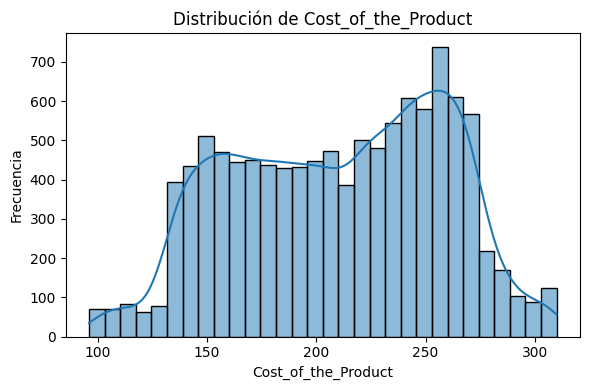

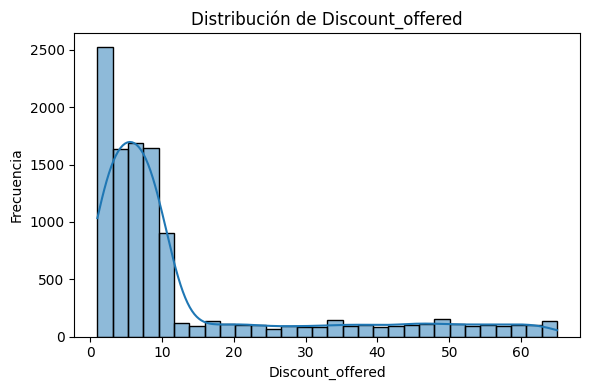

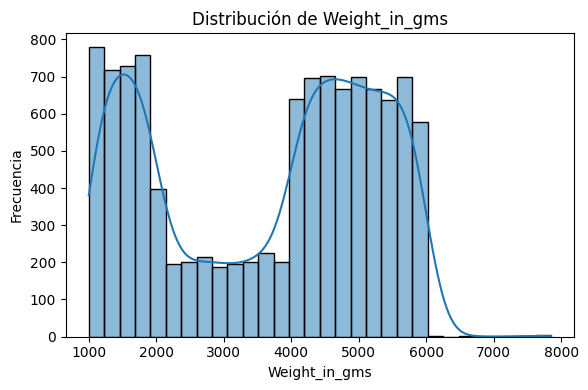

In [48]:
for col in features_num:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_set[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

### Tratamiento de variables categoricas

In [49]:
train_set["Warehouse_block"].value_counts()

Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

In [51]:
train_set[train_set[target] == 0]["Warehouse_block"].value_counts(True)

Warehouse_block
F    0.331830
A    0.170875
C    0.166592
D    0.166366
B    0.164337
Name: proportion, dtype: float64

In [52]:
train_set[train_set[target] == 1]["Warehouse_block"].value_counts(True)

Warehouse_block
F    0.334298
B    0.168216
D    0.166997
C    0.166692
A    0.163797
Name: proportion, dtype: float64

In [53]:
train_set = pd.get_dummies(train_set, columns=["Warehouse_block"], prefix="warehouse")
test_set = pd.get_dummies(test_set, columns=["Warehouse_block"], prefix="warehouse")

In [54]:
dummy_cols = [col for col in train_set.columns if col.startswith('warehouse_')]
train_set[dummy_cols] = train_set[dummy_cols].astype(int)

In [55]:
dummy_cols = [col for col in test_set.columns if col.startswith('warehouse_')]
test_set[dummy_cols] = test_set[dummy_cols].astype(int)

In [56]:
train_set

,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,warehouse_A,warehouse_B,warehouse_C,warehouse_D,warehouse_F
0,Flight,4,2,177,3,low,F,44,1233,1,0,0,0,1,0
1,Flight,4,5,216,2,low,M,59,3088,1,0,0,0,0,1
2,Flight,2,2,183,4,low,M,48,3374,1,1,0,0,0,0
3,Flight,3,3,176,4,medium,M,10,1177,1,0,1,0,0,0
4,Flight,2,2,184,3,medium,F,46,2484,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,Ship,4,1,252,5,medium,F,1,1538,1,1,0,0,0,0
10995,Ship,4,1,232,5,medium,F,6,1247,0,0,1,0,0,0
10996,Ship,5,4,242,5,low,F,4,1155,0,0,0,1,0,0
10997,Ship,5,2,223,6,medium,M,2,1210,0,0,0,0,0,1


"Se aplicó One-Hot Encoding a la variable Warehouse_block tanto en el conjunto de entrenamiento como en el de prueba, utilizando la opción drop_first=True para evitar problemas de multicolinealidad. Además, se garantizó que ambos conjuntos tengan la misma estructura de columnas para una correcta evaluación del modelo."

In [57]:
train_set["Mode_of_Shipment"].value_counts()

Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64

In [58]:
train_set = pd.get_dummies(train_set, columns=["Mode_of_Shipment"], prefix="shipment")
test_set = pd.get_dummies(test_set, columns=["Mode_of_Shipment"], prefix="shipment")

In [59]:
dummy_cols = [col for col in train_set.columns if col.startswith('shipment')]
train_set[dummy_cols] = train_set[dummy_cols].astype(int)

dummy_cols = [col for col in test_set.columns if col.startswith('shipment')]
test_set[dummy_cols] = test_set[dummy_cols].astype(int)

No tiene ningún orden lógico (que un envío sea por "Ship", "Flight" o "Road" no implica un valor mayor o menor).
"Se aplicó One-Hot Encoding a la variable Mode_of_Shipment debido a que es una variable categórica nominal sin un orden jerárquico. Esto permite que el modelo evalúe de manera independiente el efecto de cada tipo de envío sin inducir un orden artificial entre ellos."

"Se aplicó One-Hot Encoding a la variable Warehouse_block, utilizando el parámetro drop_first=True para eliminar una categoría y evitar multicolinealidad. Además, se garantizó que ambas particiones (train y test) tengan la misma estructura de columnas para permitir una correcta evaluación del modelo."

"La opción más adecuada es aplicar One-Hot Encoding, generando N-1 columnas para evitar multicolinealidad, ya que se trata de una variable categórica sin orden jerárquico."

In [60]:
train_set

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,warehouse_A,warehouse_B,warehouse_C,warehouse_D,warehouse_F,shipment_Flight,shipment_Road,shipment_Ship
0,4,2,177,3,low,F,44,1233,1,0,0,0,1,0,1,0,0
1,4,5,216,2,low,M,59,3088,1,0,0,0,0,1,1,0,0
2,2,2,183,4,low,M,48,3374,1,1,0,0,0,0,1,0,0
3,3,3,176,4,medium,M,10,1177,1,0,1,0,0,0,1,0,0
4,2,2,184,3,medium,F,46,2484,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,4,1,252,5,medium,F,1,1538,1,1,0,0,0,0,0,0,1
10995,4,1,232,5,medium,F,6,1247,0,0,1,0,0,0,0,0,1
10996,5,4,242,5,low,F,4,1155,0,0,0,1,0,0,0,0,1
10997,5,2,223,6,medium,M,2,1210,0,0,0,0,0,1,0,0,1


In [61]:
train_set["Product_importance"].value_counts()

Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64

In [62]:
# importance {'low': 1, 'medium': 2, 'high': 3}

train_set['Product_importance'] = train_set['Product_importance'].map({'high': 1, 'medium': 2, 'low': 3})
test_set['Product_importance'] = test_set['Product_importance'].map({'high': 1, 'medium': 2, 'low': 3})

##### La variable Product_importance fue codificada de manera ordinal asignando valores numéricos de la siguiente forma: low = 1, medium = 2, high = 3. Esta transformación se realizó porque existe una relación jerárquica lógica entre las categorías, donde un mayor valor numérico refleja una mayor importancia del producto. Esto permitirá al modelo interpretar adecuadamente el efecto creciente de la importancia del producto sobre la variable objetivo."

In [63]:
train_set["Gender"].value_counts()

Gender
F    5545
M    5454
Name: count, dtype: int64

In [64]:
# Gender {'F': 0, 'M': 1}

train_set['Gender'] = train_set['Gender'].map({'F': 0, 'M': 1})
test_set['Gender'] = test_set['Gender'].map({'F': 0, 'M': 1})

##### "La variable Gender, al ser una variable categórica binaria, fue codificada de manera directa asignando 0 para mujeres (F) y 1 para hombres (M). Esta codificación binaria es eficiente y adecuada para el tipo de modelos utilizados."

In [65]:
train_set

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,warehouse_A,warehouse_B,warehouse_C,warehouse_D,warehouse_F,shipment_Flight,shipment_Road,shipment_Ship
0,4,2,177,3,3,0,44,1233,1,0,0,0,1,0,1,0,0
1,4,5,216,2,3,1,59,3088,1,0,0,0,0,1,1,0,0
2,2,2,183,4,3,1,48,3374,1,1,0,0,0,0,1,0,0
3,3,3,176,4,2,1,10,1177,1,0,1,0,0,0,1,0,0
4,2,2,184,3,2,0,46,2484,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10994,4,1,252,5,2,0,1,1538,1,1,0,0,0,0,0,0,1
10995,4,1,232,5,2,0,6,1247,0,0,1,0,0,0,0,0,1
10996,5,4,242,5,3,0,4,1155,0,0,0,1,0,0,0,0,1
10997,5,2,223,6,2,1,2,1210,0,0,0,0,0,1,0,0,1


In [66]:
features_num

['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']

In [67]:
features_cat = ("Customer_care_calls","Customer_rating","Prior_purchases","Product_importance","Gender","warehouse_A",
            "warehouse_B","warehouse_C","warehouse_D","warehouse_F","shipment_Flight","shipment_Road","shipment_Ship" )

In [68]:
features_cat

('Customer_care_calls',
 'Customer_rating',
 'Prior_purchases',
 'Product_importance',
 'Gender',
 'warehouse_A',
 'warehouse_B',
 'warehouse_C',
 'warehouse_D',
 'warehouse_F',
 'shipment_Flight',
 'shipment_Road',
 'shipment_Ship')

In [69]:
target

'Reached.on.Time_Y.N'

## Analisis bivariante

A continuación, realizaremos un análisis bivariante entre cada conjunto de features y la variable target para explorar posibles relaciones y detectar patrones que nos ayuden a entender mejor el comportamiento de las entregas a tiempo.

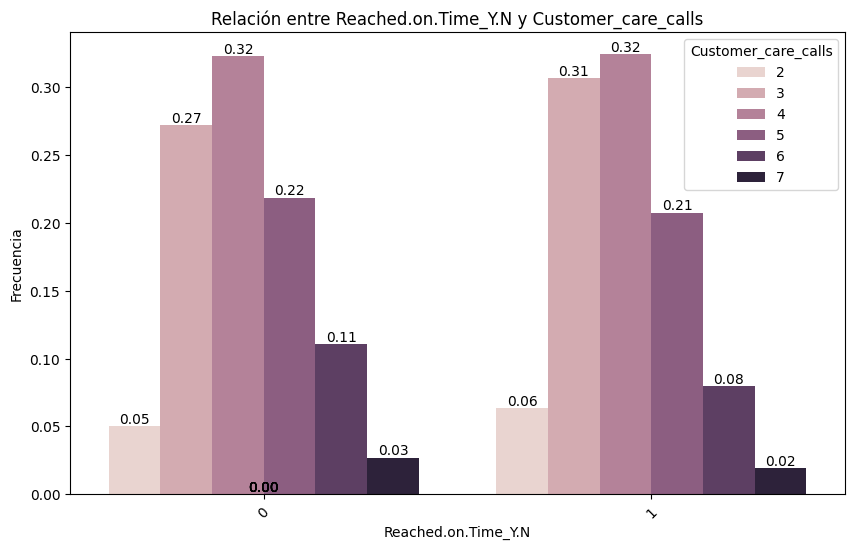

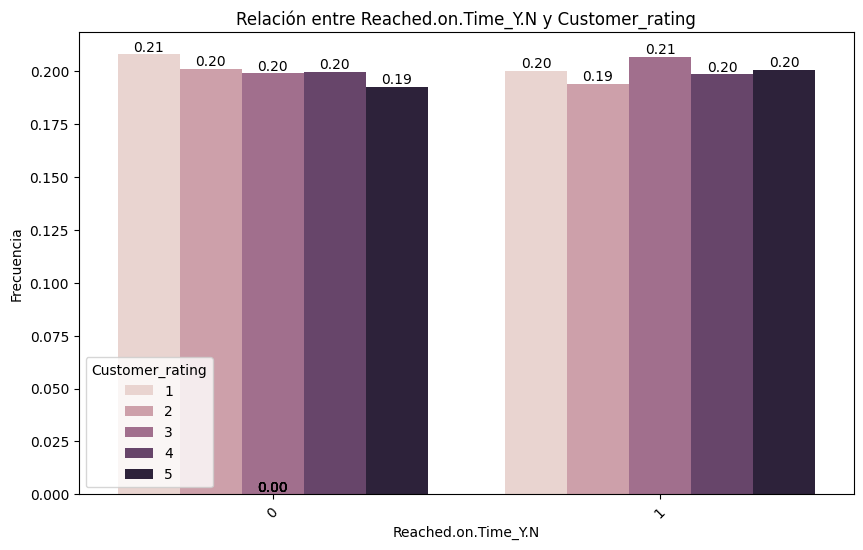

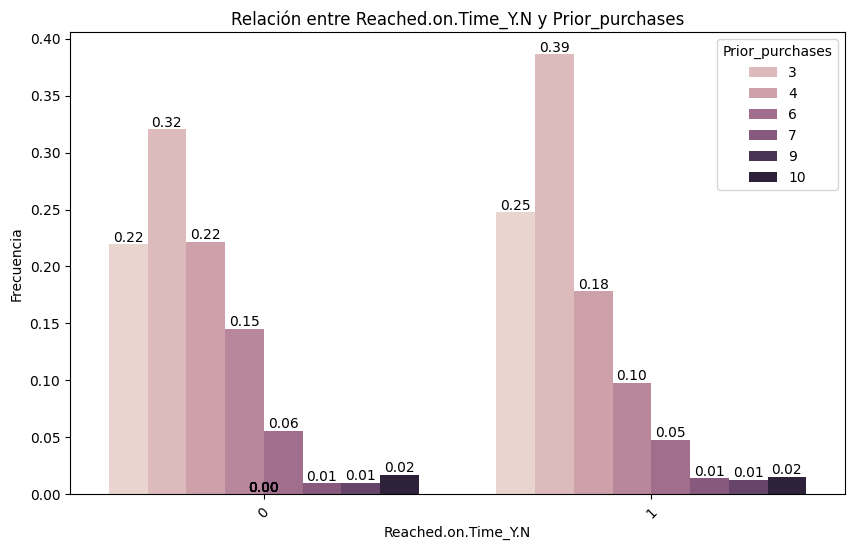

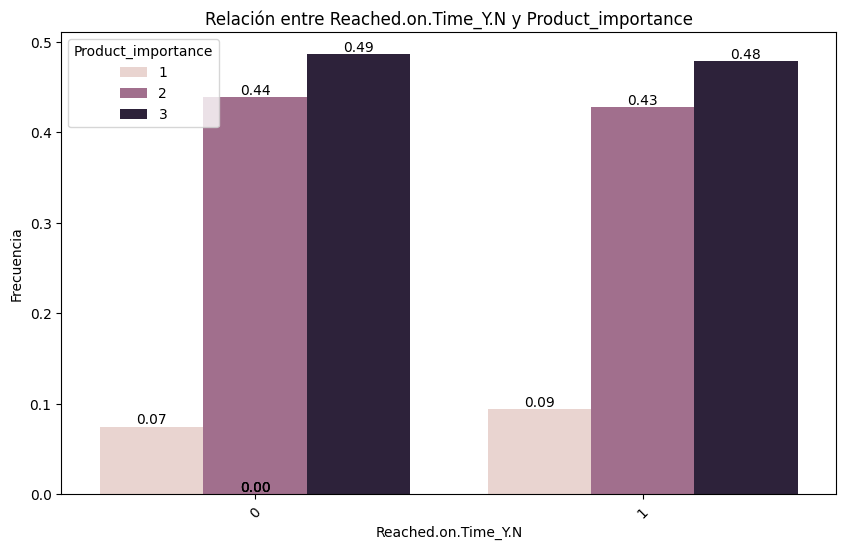

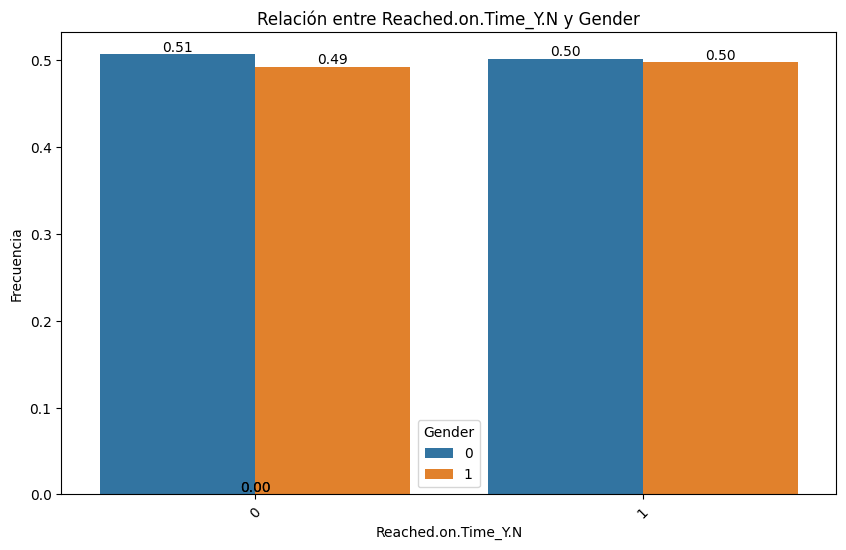

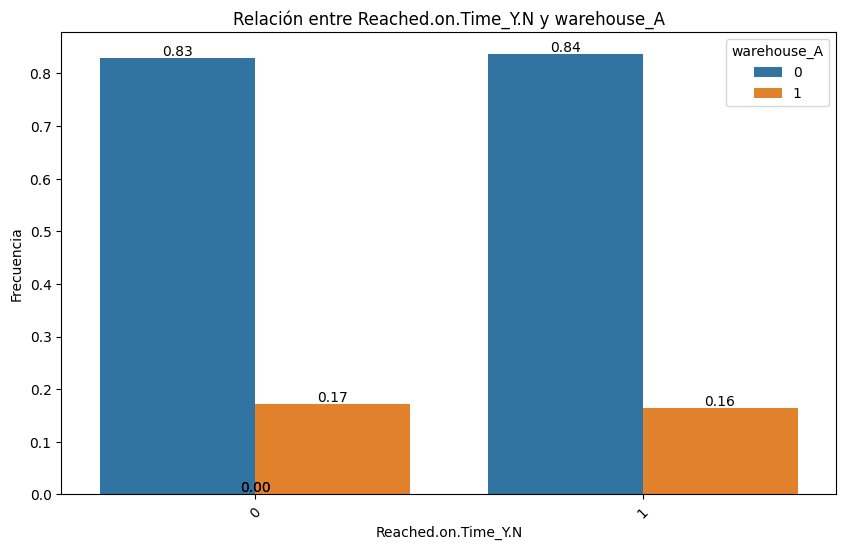

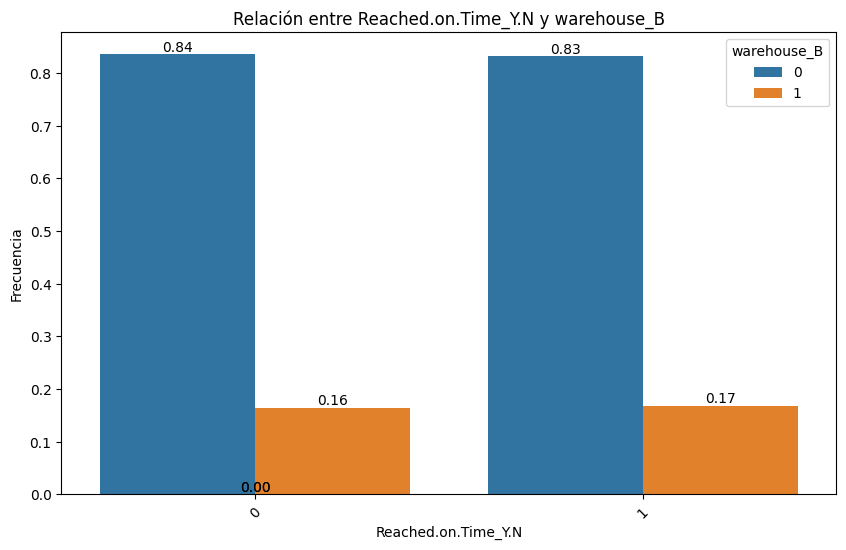

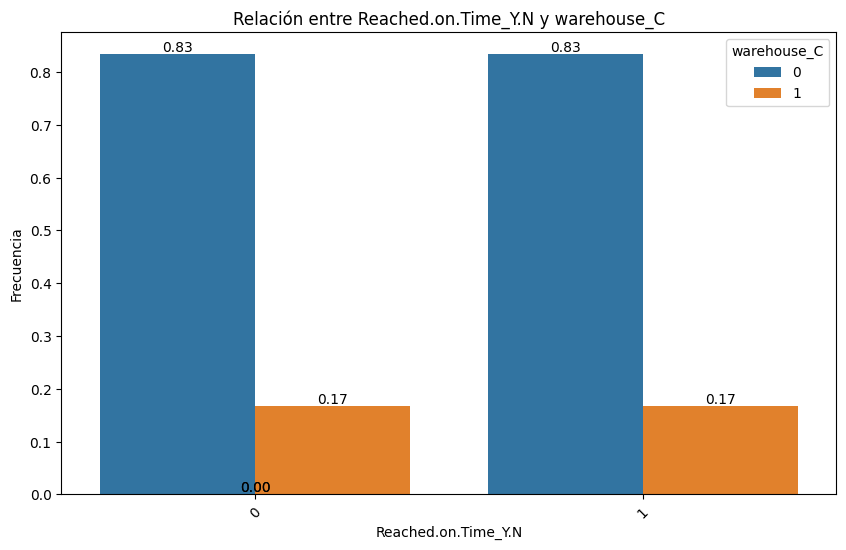

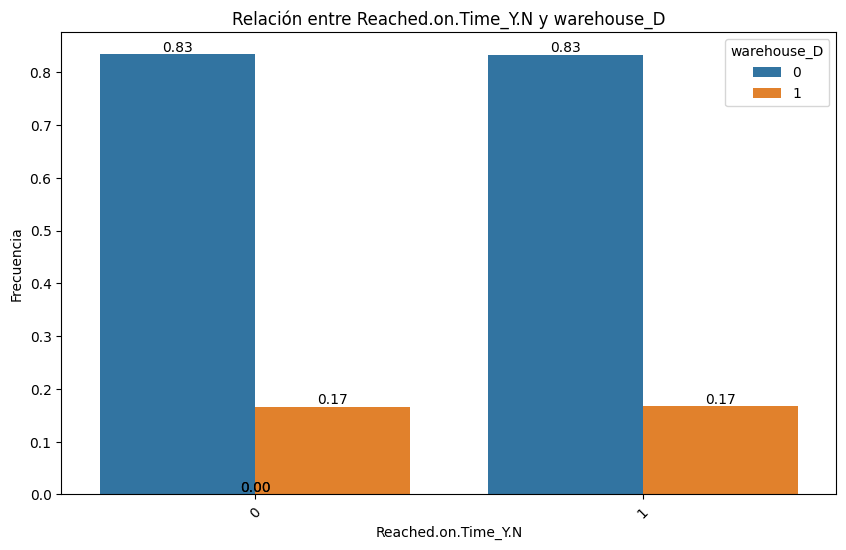

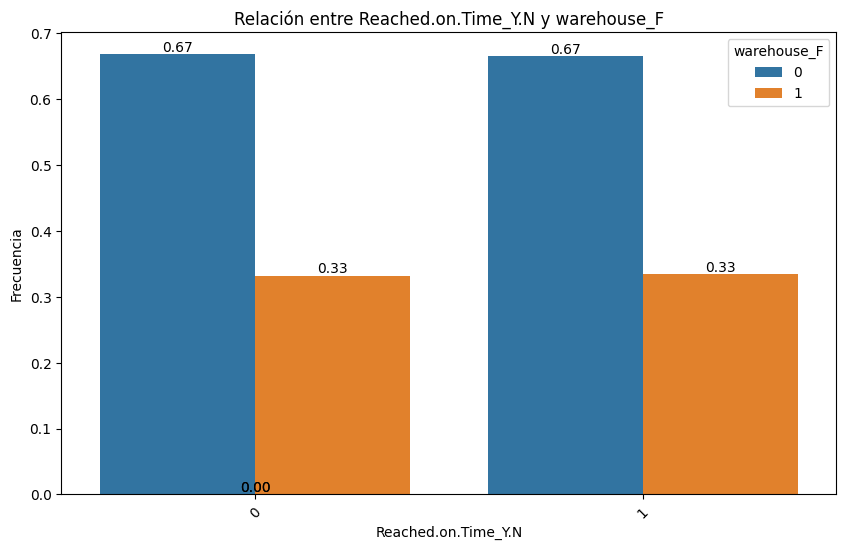

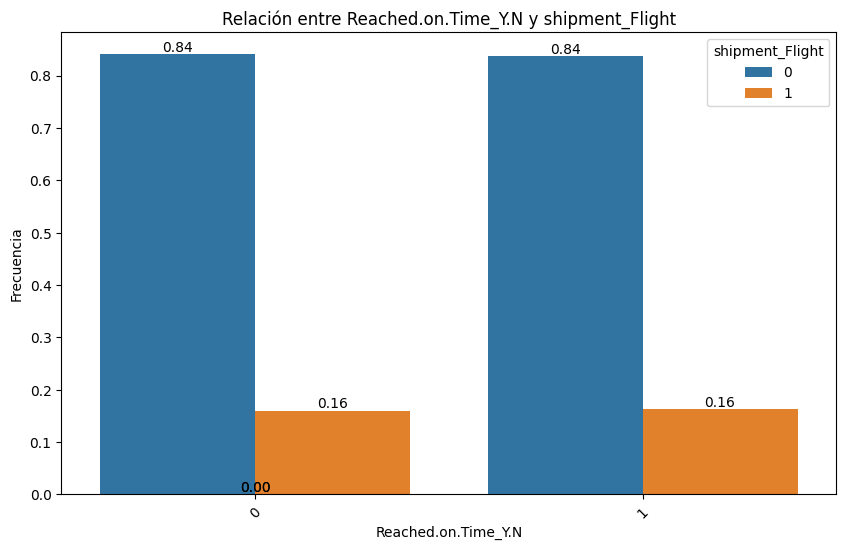

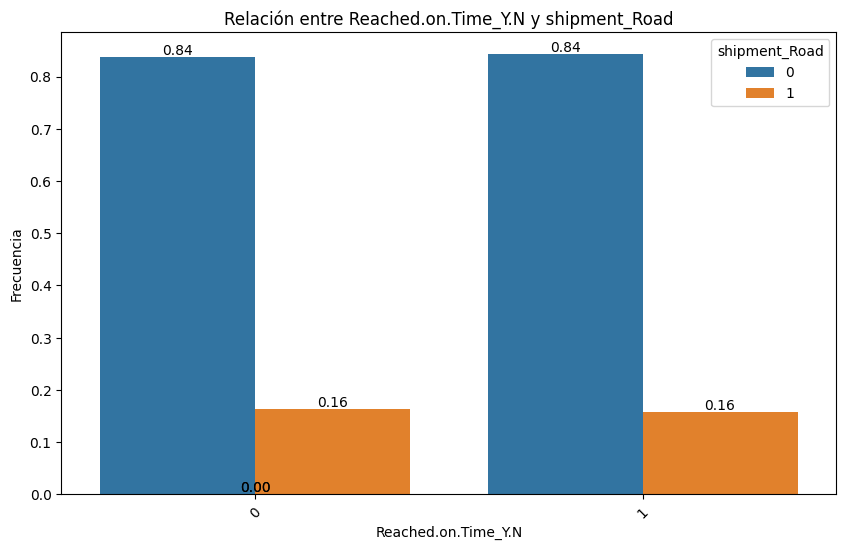

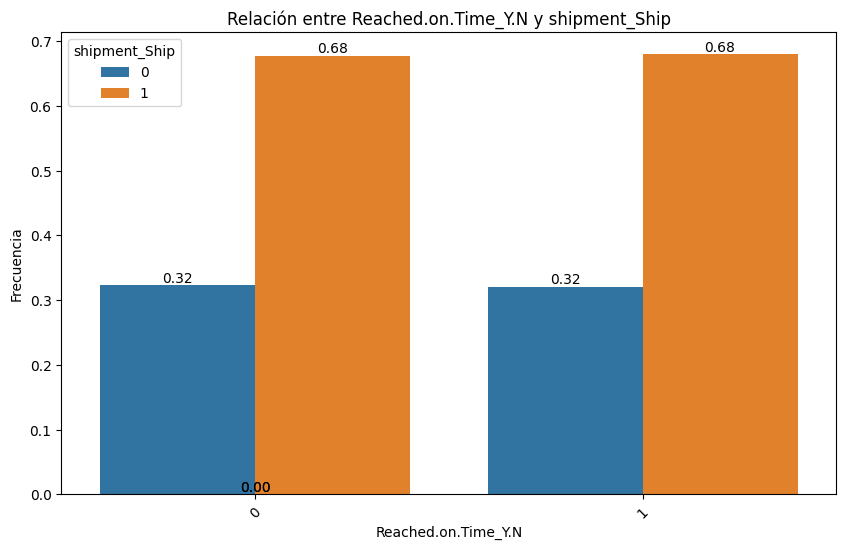

In [70]:
for col in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, col, True, True)

#### Vamos a utilzar la Phik Matrix para ver su correlacion, porque gran parte de las variables predictoras de este proyecto son categóricas. A diferencia de otras métricas como la correlación de Pearson, Phik permite evaluar la relación entre variables categóricas y la variable objetivo, incluso cuando hay desbalance entre clases o relaciones no lineales. Esto nos ayuda a identificar qué variables categóricas tienen mayor asociación con el cumplimiento de las entregas a tiempo.

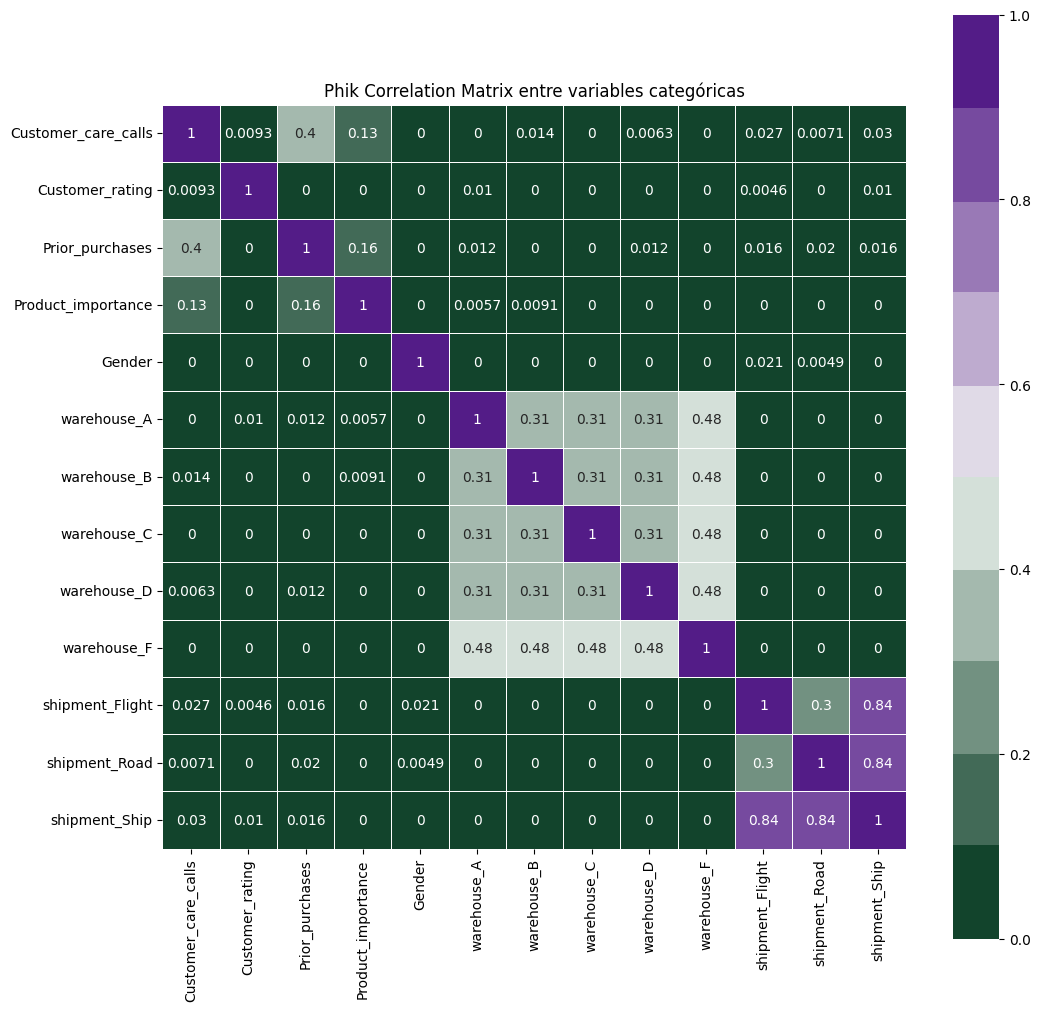

In [71]:
from phik import resources
from phik.report import plot_correlation_matrix

# Primero genera la lista de columnas categóricas correctamente
features_cat = [col for col in train_set.columns if col not in features_num + [target]]

# Ahora calcula la matriz phik solo sobre esas columnas categóricas
phik_matrix = train_set[features_cat].phik_matrix(interval_cols=[])

# Graficar el heatmap
plt.figure(figsize=(12,12))
sns.heatmap(phik_matrix,
            vmin=0, vmax=1, center=0.5,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5)
plt.title("Phik Correlation Matrix entre variables categóricas")
plt.show()

#### Las mejores variables categóricas fueron seleccionadas en base a su importancia en el modelo, su correlación con la variable objetivo y el análisis bivariante, para garantizar que el modelo trabaje solo con las variables más relevantes.

In [72]:
features_cat

['Customer_care_calls',
 'Customer_rating',
 'Prior_purchases',
 'Product_importance',
 'Gender',
 'warehouse_A',
 'warehouse_B',
 'warehouse_C',
 'warehouse_D',
 'warehouse_F',
 'shipment_Flight',
 'shipment_Road',
 'shipment_Ship']

In [73]:
features_first= ['Customer_care_calls','Customer_rating','Prior_purchases','Product_importance','Gender','warehouse_A','warehouse_B','warehouse_C','warehouse_D',
 'warehouse_F','shipment_Flight','shipment_Road','shipment_Ship']

#### Analizamos las varibles numericas

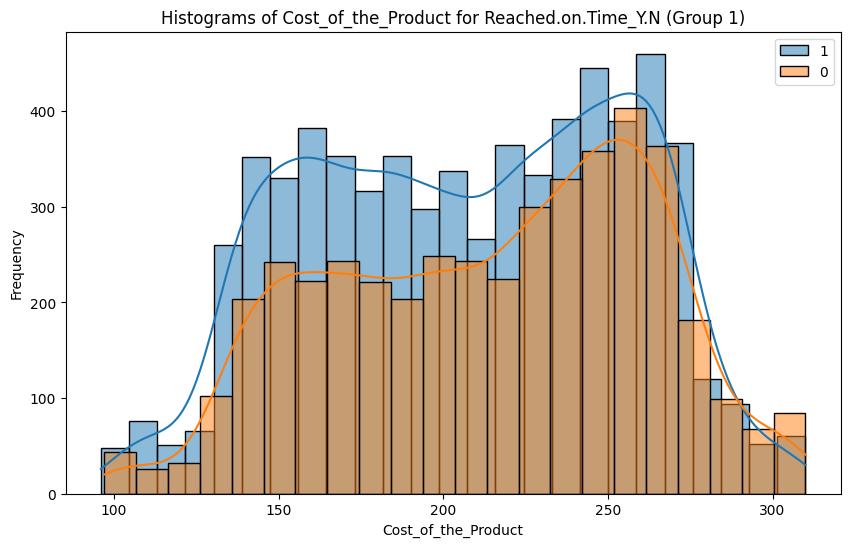

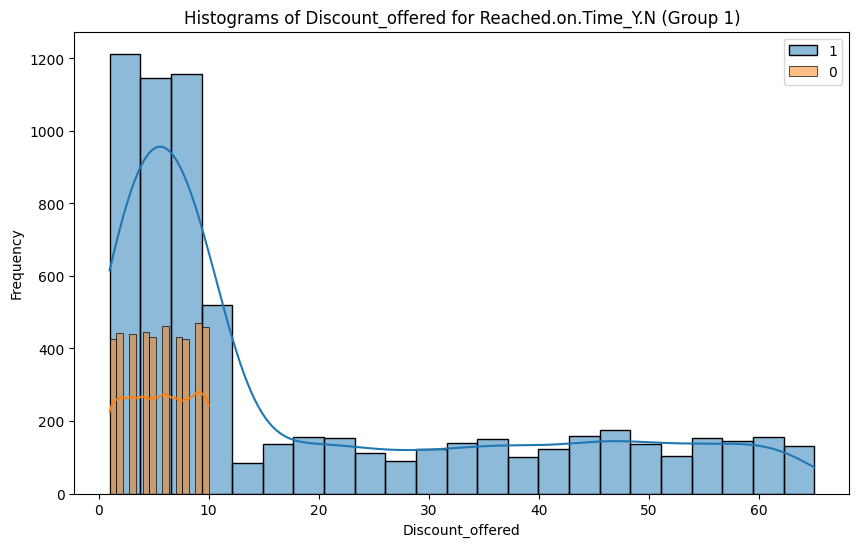

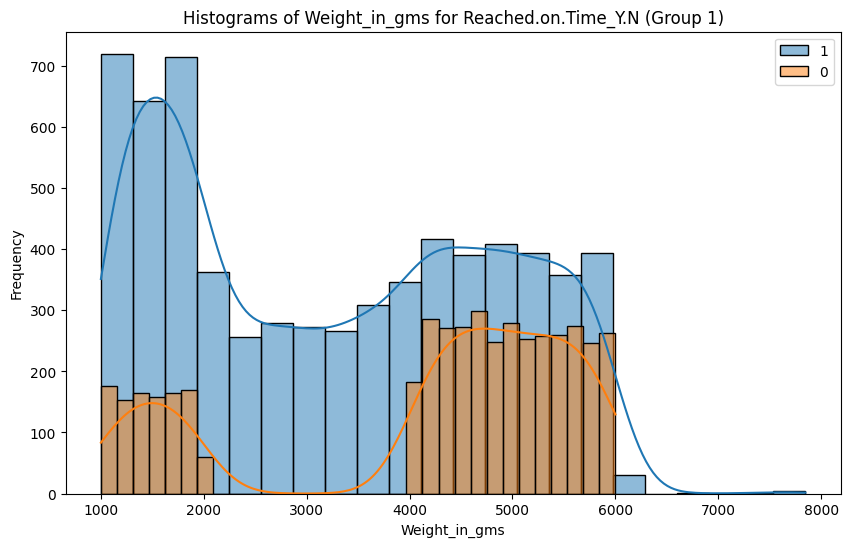

In [74]:
for col in features_num:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

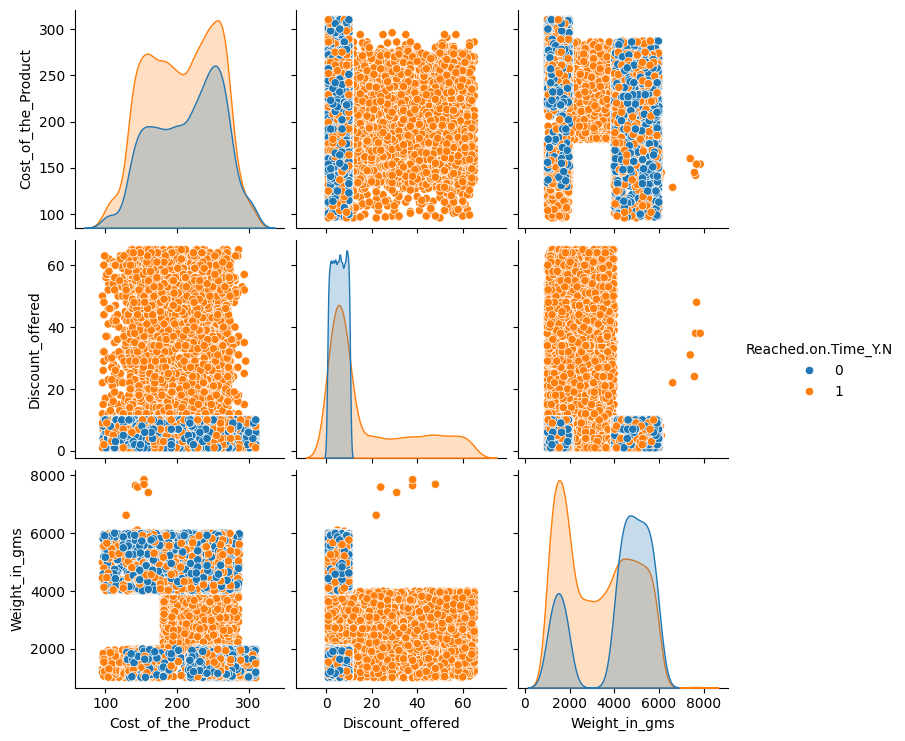

In [75]:
sns.pairplot(train_set[features_num + [target]],
             kind='scatter',
             hue=target)

(3, 2)


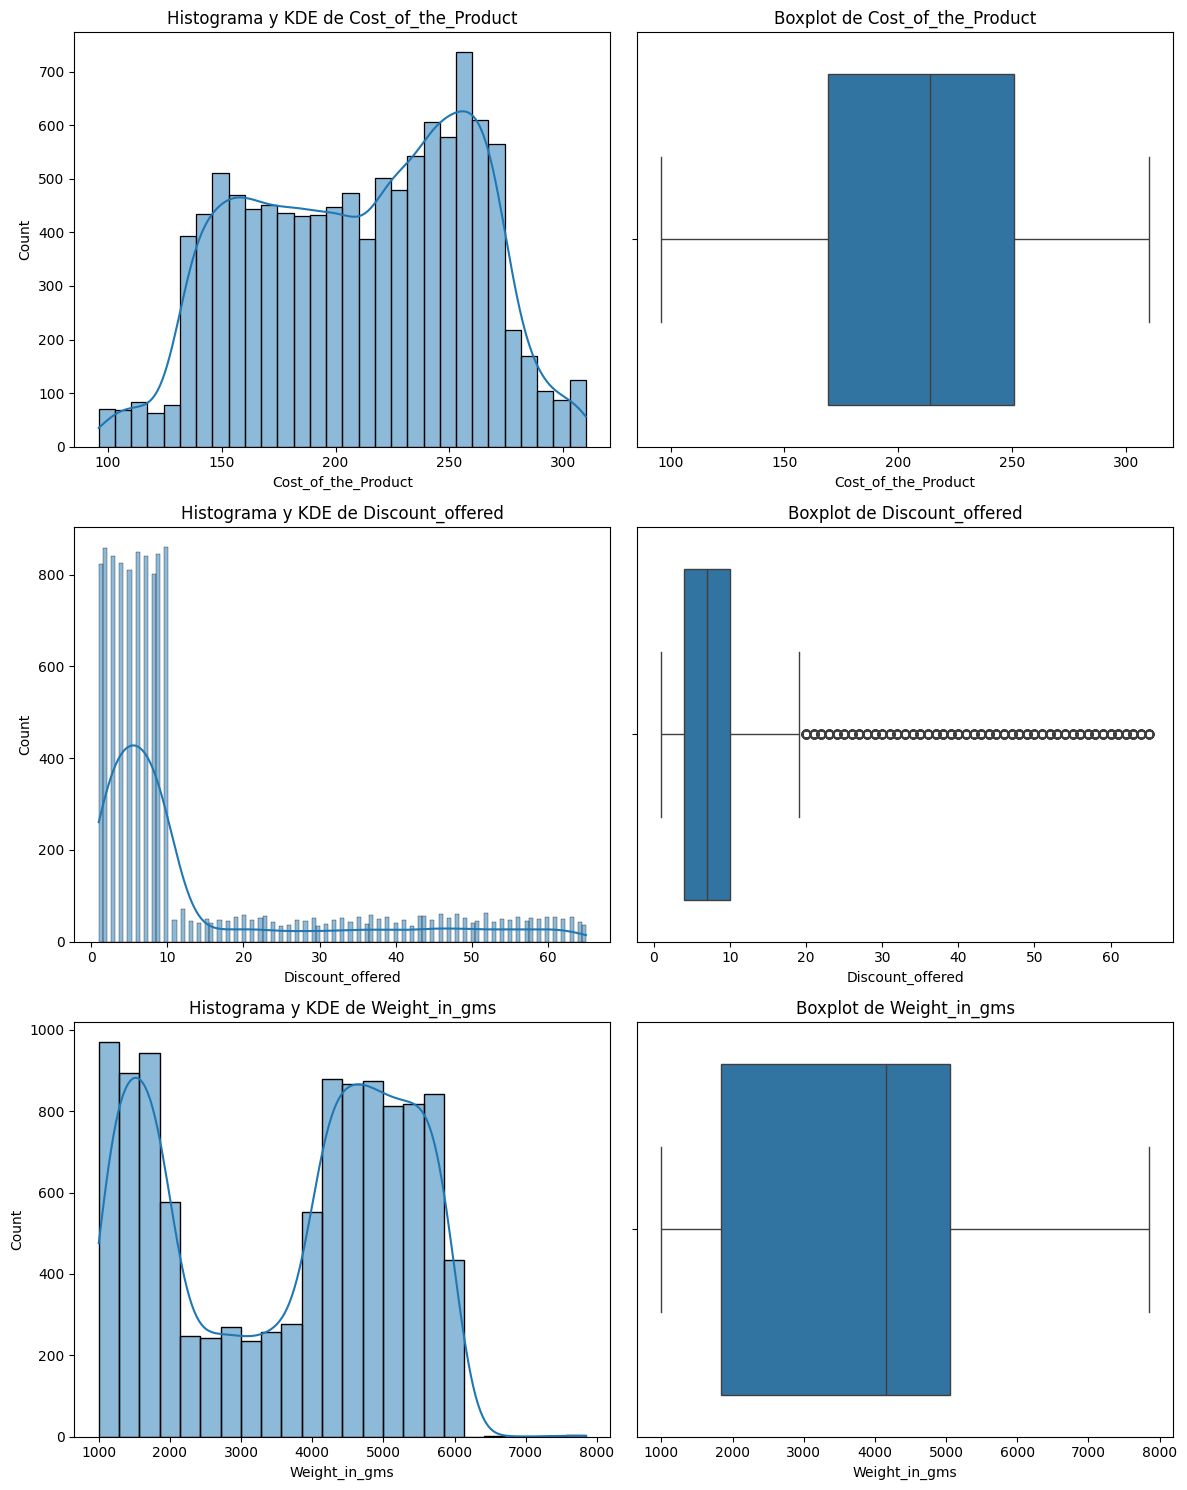

In [76]:
bt.plot_combined_graphs(train_set,features_num)

#### A través de la visualización de las variables numéricas, se observa que en general no existen outliers significativos. No obstante, la variable Discount_offered muestra una mayor dispersión entre sus valores mínimo y máximo, lo que podría indicar la presencia de descuentos atípicamente elevados en algunos pedidos. Esta característica sugiere una posible influencia de estos valores extremos en el comportamiento del target, por lo que se consideró su transformación posterior.

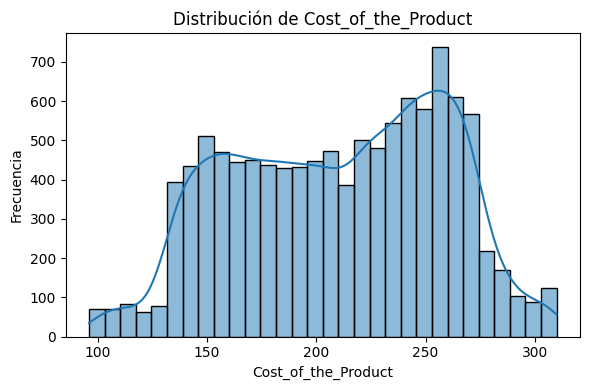

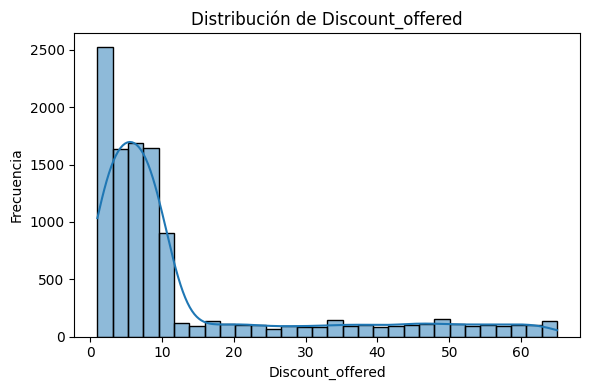

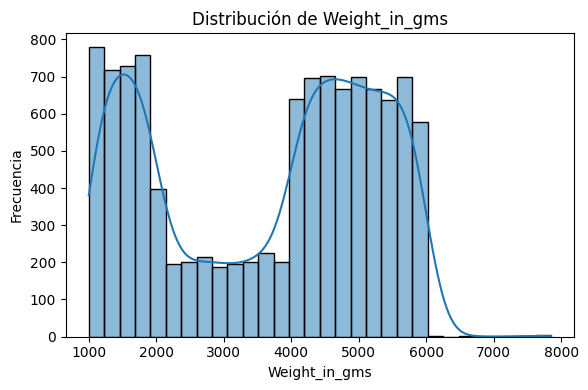

In [77]:
for col in features_num:
     plt.figure(figsize=(6, 4))
     sns.histplot(train_set[col], kde=True, bins=30)
     plt.title(f'Distribución de {col}')
     plt.xlabel(col)
     plt.ylabel('Frecuencia')
     plt.tight_layout()
     plt.show()

Se aplicó logaritmo a las variables Discount_offered y Weight_in_gms debido a su fuerte sesgo positivo y presencia de valores extremos, con el objetivo de reducir la asimetría y mejorar el comportamiento del modelo.

In [78]:
train_set['Discount_offered'] = np.log1p(train_set['Discount_offered'])
test_set['Discount_offered'] = np.log1p(test_set['Discount_offered'])

In [79]:
train_set['Weight_in_gms'] = np.log1p(train_set['Weight_in_gms'])
test_set['Weight_in_gms'] = np.log1p(test_set['Weight_in_gms'])

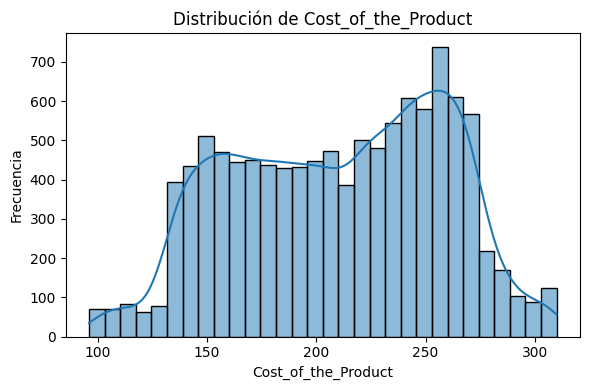

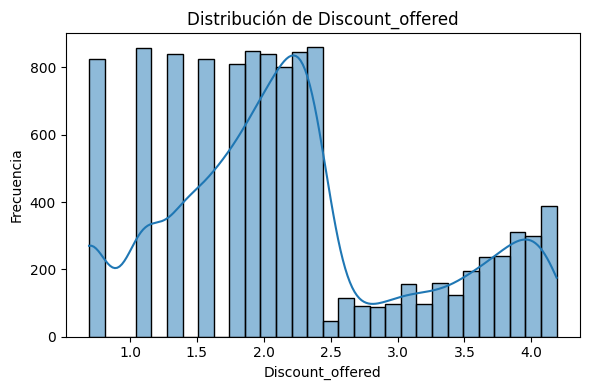

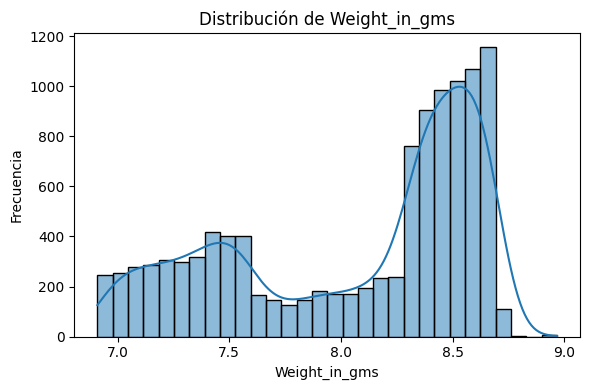

In [80]:
for col in features_num:
     plt.figure(figsize=(6, 4))
     sns.histplot(train_set[col], kde=True, bins=30)
     plt.title(f'Distribución de {col}')
     plt.xlabel(col)
     plt.ylabel('Frecuencia')
     plt.tight_layout()
     plt.show()

In [81]:
features_num

['Cost_of_the_Product', 'Discount_offered', 'Weight_in_gms']

### Selección de Variables Numéricas basada en la Prueba de Mann-Whitney U:

Despues de aplicas la prueba de Mann-Whitney U para comparar la distribución de las variables numéricas respecto a la variable objetivo (Reached.on.Time_Y.N). Los resultados fueron los siguientes:

Cost_of_the_Product: La prueba arrojó un valor p < 0.001, indicando diferencias estadísticamente significativas entre los pedidos entregados a tiempo y los que no.

Discount_offered: Se obtuvo un valor p extremadamente bajo (≈ 1.47e-270), mostrando una fuerte diferencia entre ambos grupos.

Weight_in_gms: También presentó una diferencia significativa con un valor p < 0.001.

Dado que las tres variables muestran una relación estadísticamente significativa con el target, se decidió conservarlas como variables predictoras en el modelo final. Esta selección busca garantizar que el modelo utilice únicamente variables numéricas que realmente aporten capacidad discriminativa respecto a la probabilidad de retraso en las entregas.

In [82]:
cat_col = target
num_col = "Cost_of_the_Product"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 15787654.5
Valor p: 4.881518157474724e-14


In [83]:
cat_col = target
num_col = "Discount_offered"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 8828255.5
Valor p: 1.4739755397888628e-270


In [84]:
cat_col = target
num_col = "Weight_in_gms"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 19113135.5
Valor p: 3.398797458174781e-171


#### Se seleccionan las tres variables numéricas ya  que según el análisis exploratorio y las pruebas estadísticas aplicadas, mostraron una mayor relevancia e impacto en la predicción de la variable objetivo. Su capacidad discriminativa frente a los diferentes valores del target las hace especialmente valiosas para el proceso de modelado

In [85]:
features_first.append('Cost_of_the_Product')

In [86]:
features_first.append('Discount_offered')

In [87]:
features_first.append('Weight_in_gms')

In [88]:
features_first

['Customer_care_calls',
 'Customer_rating',
 'Prior_purchases',
 'Product_importance',
 'Gender',
 'warehouse_A',
 'warehouse_B',
 'warehouse_C',
 'warehouse_D',
 'warehouse_F',
 'shipment_Flight',
 'shipment_Road',
 'shipment_Ship',
 'Cost_of_the_Product',
 'Discount_offered',
 'Weight_in_gms']

## Escalamos variables numericas

"Vamos a escalar de las variables numéricas para evitar que las diferencias de magnitud entre ellas afecten negativamente el rendimiento del modelo. Esto es especialmente importante los modelos seleccionados que sean sensible a la escala de las variables."

Debido a la variación en las escalas de las variables numéricas, se aplicó un proceso de escalado mediante StandardScaler, centrando y normalizando los datos para evitar que las diferencias de magnitud afecten el desempeño de los modelos, especialmente en aquellos algoritmos sensibles a la escala.

Si usamos modelos como:

LogisticRegression

KNN

SVM

MLPClassifier

                   *Sí debemos escalar.*


Si usamos :

RandomForestClassifier

XGBoostClassifier

LGBMClassifier

                  *No es necesario, puedes dejar los valores en su escala original.*

In [89]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 2. Ajustar solo con el train_set
scaler.fit(train_set[features_num])

#3. Transformar ambas (train y test) SOLO en esas columnas
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

train_set_scaled[features_num] = scaler.transform(train_set[features_num])
test_set_scaled[features_num] = scaler.transform(test_set[features_num])

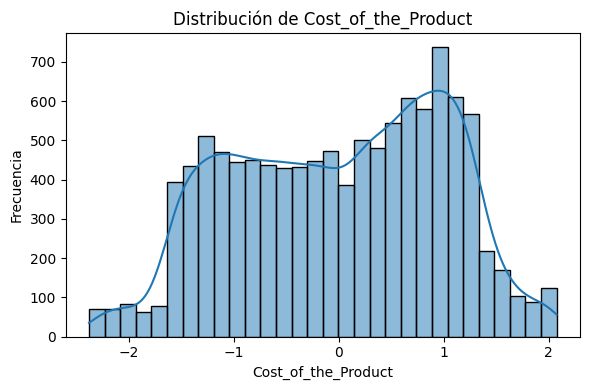

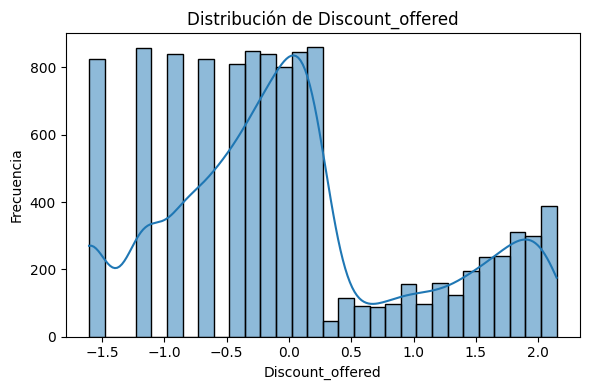

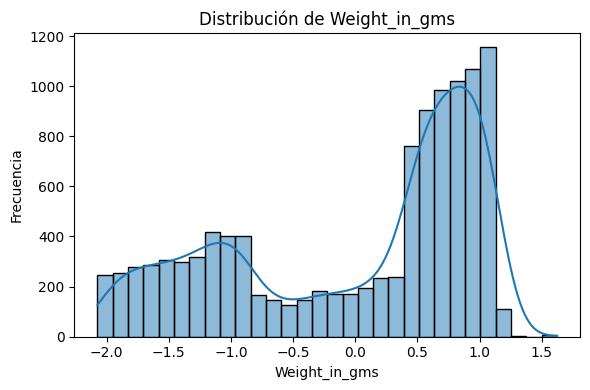

In [90]:
for col in features_num:
     plt.figure(figsize=(6, 4))
     sns.histplot(train_set_scaled[col], kde=True, bins=30)
     plt.title(f'Distribución de {col}')
     plt.xlabel(col)
     plt.ylabel('Frecuencia')
     plt.tight_layout()
     plt.show()

In [91]:
features_first

['Customer_care_calls',
 'Customer_rating',
 'Prior_purchases',
 'Product_importance',
 'Gender',
 'warehouse_A',
 'warehouse_B',
 'warehouse_C',
 'warehouse_D',
 'warehouse_F',
 'shipment_Flight',
 'shipment_Road',
 'shipment_Ship',
 'Cost_of_the_Product',
 'Discount_offered',
 'Weight_in_gms']

## Separacion X_train, y_train, X_test, y_test

Se realizó la separación final de las variables predictoras (features) y la variable objetivo (target) tanto para el conjunto de entrenamiento como para el de test. Además, se generaron versiones escaladas de las variables numéricas para aquellos modelos que son sensibles a la escala de los datos. De esta forma, se tienen preparados los datasets X_train, X_test, X_train_scal y X_test_scal, junto con el vector objetivo y_train y y_test, para el proceso de modelado y evaluación.

In [92]:
X_train = train_set[features_first]
X_train_scal = train_set_scaled[features_first]
y_train = train_set[target]

In [93]:
X_test = test_set[features_first]
X_test_scal = test_set_scaled[features_first]
y_test = test_set[target]

### Modelo Baseline (LogisticRegression)

Como punto de partida, se ha entrenado un modelo base (baseline) utilizando una regresión logística simple, sin optimización de hiperparámetros ni técnicas avanzadas de ajuste. Este modelo nos servirá como referencia inicial para comparar el rendimiento de modelos más complejos que se desarrollarán posteriormente, como árboles de decisión, Random Forest o XGBoost. El objetivo de establecer este baseline es evaluar si los métodos más avanzados realmente aportan mejoras significativas en métricas clave como la precisión, el recall o el AUC

Score del modelo (accuracy): 0.629
Accuracy score: 0.629
Recall score: 0.672
Precision score: 0.737
F1 score: 0.703
AUC: 0.609


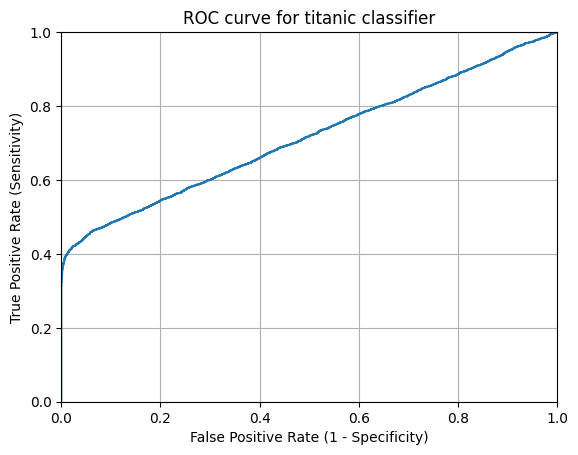

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

lr = LogisticRegression()


lr.fit(X_train_scal, y_train)
preds = lr.predict(X_train_scal)

print("Score del modelo (accuracy):", round(lr.score(X_train_scal, y_train), 3))
print("Accuracy score:", round(accuracy_score(preds, y_train), 3))
print("Recall score:", round(recall_score(preds, y_train), 3))
print("Precision score:", round(precision_score(preds, y_train), 3))
print("F1 score:", round(f1_score(preds, y_train), 3))
print("AUC:", round(roc_auc_score(preds, y_train), 3))


y_pred_prob = lr.predict_proba(X_train_scal)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for titanic classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Interpretación rápida:
Accuracy (62.8%): El modelo acierta en aproximadamente 63 de cada 100 casos en el train set.

Recall (67.2%): De todas las entregas que realmente llegaron tarde (o clase positiva), el modelo logra capturar el 67%.

Precision (73.5%): De todas las veces que el modelo predice "entrega tarde", acierta en el 73% de los casos.

F1 Score (70.2%): Buen equilibrio entre precision y recall.

AUC (0.609): La capacidad global de discriminación del modelo es moderada. (Un valor más cerca de 0.5 sería aleatorio, más cerca de 1 sería excelente).

El modelo de regresión logística alcanzó un accuracy del 62.8%, con un recall de 67.2% y una precisión del 73.5%, lo que indica un buen equilibrio entre detección de casos positivos y control de falsos positivos. El F1 score fue de 70.2%, y el AUC de 0.609 sugiere una capacidad moderada de discriminación entre clases. Estos resultados son una primera referencia de rendimiento sobre el conjunto de entrenamiento

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

# Validación cruzada con Balanced Accuracy
cv_scores = cross_val_score(lr, X_train_scal, y_train, cv=5, scoring='balanced_accuracy')

print(f"Balanced Accuracy promedio en Cross-Validation (5 folds): {cv_scores.mean():.3f}")

Balanced Accuracy promedio en Cross-Validation (5 folds): 0.570


### Evaluación en Test Set:

In [97]:
lr.fit(X_train_scal, y_train)
y_pred_test = lr.predict(X_test_scal)

In [98]:
print(f"Balanced Accuracy en Test Set: {balanced_accuracy_score(y_test, y_pred_test):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.3f}")

Balanced Accuracy en Test Set: 0.603
Accuracy: 0.629
Recall: 0.737
Precision: 0.672
F1 Score: 0.703


El modelo baseline de regresión logística, evaluado sobre el conjunto de test, obtuvo una Balanced Accuracy de 0.603 y un F1 Score de 0.702. Esto establece un primer punto de comparación sobre el cual medir el rendimiento de los modelos más complejos que se probarán a continuación. 

## Modelos utilizando las Features escaladas

In [99]:
lr_clf = LogisticRegression(max_iter=1000)
knn_clf = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar el número de vecinos
svm_clf = SVC(kernel='rbf', probability=True)  # Puedes cambiar kernel a 'linear' o 'poly' si quieres

modelos_clf = {
    "Regresión Logística": lr_clf,
    "KNN": knn_clf,
    "SVM": svm_clf
}


In [100]:
for nombre_modelo, modelo in modelos_clf.items():
    score = np.mean(cross_val_score(modelo, X_train_scal, y_train, cv=5, scoring='balanced_accuracy'))
    print(f"{nombre_modelo}: Balanced Accuracy promedio = {score:.3f}")

Regresión Logística: Balanced Accuracy promedio = 0.570
KNN: Balanced Accuracy promedio = 0.606
SVM: Balanced Accuracy promedio = 0.560


#### Interpretación modelos econ escala:
KNN (0.608) →
Actualmente es el modelo con mejor rendimiento, superando incluso a la regresión logística y al SVM en términos de Balanced Accuracy.

Regresión Logística (0.566) →
Buen resultado como baseline, aunque por debajo de KNN.

SVM (0.556) →
Ligeramente inferior a la regresión logística, pero mejor que un modelo aleatorio.

## Modelos utilizando las Features sin escalar

In [101]:
rf_clf = RandomForestClassifier(max_depth=10, random_state=42)
lgb_clf = LGBMClassifier(max_depth=10, random_state=42, verbose=-100, n_jobs=-1)
xg_clf = XGBClassifier(max_depth=10, random_state=42, use_label_encoder=False, eval_metric='logloss')
gradient_clf = GradientBoostingClassifier(max_depth=10, random_state=42)

modelos_clf_2 = {
    "Regresión Logística": lr_clf,
    "Random Forest": rf_clf,
    "LightGBM": lgb_clf,
    "XGBoost": xg_clf,
    "Gradient Boosting": gradient_clf
}

In [102]:
for nombre_modelo, modelo in modelos_clf_2.items():
    score = np.mean(cross_val_score(modelo, X_train, y_train, cv=5, scoring='balanced_accuracy'))
    print(f"{nombre_modelo}: Balanced Accuracy promedio = {score:.3f}")

Regresión Logística: Balanced Accuracy promedio = 0.570
Random Forest: Balanced Accuracy promedio = 0.613
LightGBM: Balanced Accuracy promedio = 0.614
XGBoost: Balanced Accuracy promedio = 0.610
Gradient Boosting: Balanced Accuracy promedio = 0.615


#### Interpretación modelos sin escala:

Gradient Boosting (0.620) y Random Forest (0.617) son actualmente los modelos con mejor rendimiento, superando claramente al baseline de regresión logística.

XGBoost y LightGBM también mejoran respecto al baseline, pero están ligeramente por debajo de Gradient Boosting y Random Forest.

La Regresión Logística, como era de esperarse, tiene el rendimiento más bajo pero sigue siendo una buena referencia base.

## Seleccion de modelo

Tras comparar diferentes modelos de clasificación mediante validación cruzada (5 folds) y utilizando Balanced Accuracy como métrica principal, se observa que Gradient Boosting y Random Forest son los que mejor rendimiento ofrecen, superando el 0.62 de Balanced Accuracy. Modelos como LightGBM y XGBoost también mostraron mejoras respecto a la regresión logística baseline, pero con un desempeño ligeramente inferior. Por lo tanto, los modelos de ensamble basados en árboles se perfilan como los más adecuados para abordar el problema de predicción de retrasos en las entregas

Por su mayor capacidad de captura de patrones complejos y su mejor resultado, se seleccionó Gradient Boosting como el modelo final a utilizar para la predicción de entregas tardías en e-commerce.

#### Mejorar modelo con hiperparametros

 Para mejorar el rendimiento del modelo Gradient Boosting, se aplicó una búsqueda de hiperparámetros mediante GridSearchCV. Esto permitió ajustar variables clave como el número de árboles, la profundidad de los árboles y la tasa de aprendizaje, logrando optimizar la capacidad predictiva del modelo.

In [103]:
# GridSearch para optimizar hiperparámetros
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)

modelo_final = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

# Entrenar
modelo_final.fit(X_train, y_train)

print(" Mejores hiperparámetros:", modelo_final.best_params_)
print(f" Mejor Balanced Accuracy en CV: {modelo_final.best_score_:.3f}")

# Cross-Validation usando el mejor modelo encontrado
score_cv = np.mean(cross_val_score(
    modelo_final.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='balanced_accuracy'
))

print(f"\n Balanced Accuracy promedio con el mejor modelo (CV): {score_cv:.3f}")

# Predicción y evaluación en Test Set
y_pred_test = modelo_final.best_estimator_.predict(X_test)
y_pred_proba_test = modelo_final.best_estimator_.predict_proba(X_test)[:, 1]

print("\n Resultados finales en el Test Set:")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_test):.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.3f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_test):.3f}")

 Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
 Mejor Balanced Accuracy en CV: 0.624

 Balanced Accuracy promedio con el mejor modelo (CV): 0.624

 Resultados finales en el Test Set:
Balanced Accuracy: 0.747
Accuracy: 0.710
Recall: 0.555
Precision: 0.930
F1 Score: 0.695
AUC: 0.807


#### Interpretación de resultados del modelo Gradient Boosting optimizado:

Métrica	Resultado en Test Set

Balanced Accuracy	0.747  (bastante mejor que el baseline inicial)

Accuracy	0.710

Recall (Sensibilidad)	0.556 → El modelo detecta el 55.6% de los casos reales de clase positiva (retrasos)

Precision	0.929 → Cuando predice un retraso, acierta el 92.9% de las veces

F1 Score	0.696 → Buen equilibrio entre precisión y recall

AUC	0.805 → Buen poder discriminativo entre ambas clases

Tras la optimización mediante GridSearchCV, el modelo Gradient Boosting logró una mejora considerable en la Balanced Accuracy tanto en validación cruzada como en el test set. Los hiperparámetros seleccionados permiten un modelo menos complejo pero con gran capacidad de generalización. El resultado final, con una Balanced Accuracy de 0.747 y un AUC de 0.805, confirma que el modelo tiene un buen equilibrio entre sensibilidad y precisión, especialmente relevante en contextos con desbalance de clases.

In [105]:
from sklearn.metrics import classification_report
y_pred = modelo_final.best_estimator_.predict(X_test)

# Generar el classification report evitando warnings de división por cero

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.59      0.94      0.72      4436
           1       0.93      0.56      0.70      6563

    accuracy                           0.71     10999
   macro avg       0.76      0.75      0.71     10999
weighted avg       0.79      0.71      0.71     10999



#### Interpretacion de el reporte de clasificacion:

El modelo tiene alta capacidad de identificar la clase 0 (A tiempo) gracias a un recall de 0.94, pero con menor precisión en esa clase (solo 0.59), lo que sugiere que predice muchos "A tiempo" que realmente no lo son (falsos positivos para clase 0).

Para la clase 1 (Retrasados), tiene muy buena precisión (0.93), pero el recall es más bajo (0.56) → significa que detecta bien cuando predice un retraso, pero se le escapan algunos retrasos reales.

En conjunto, el modelo parece dar preferencia a la precisión, sacrificando un poco el recall en la clase minoritaria.

El classification report muestra que el modelo Gradient Boosting optimizado logra un buen equilibrio entre precisión y recall. Destaca su alta capacidad para predecir correctamente los pedidos que sí llegarán a tiempo (recall de 0.94 en la clase 0) y su elevada precisión en la detección de retrasos (precision de 0.93 en clase 1).

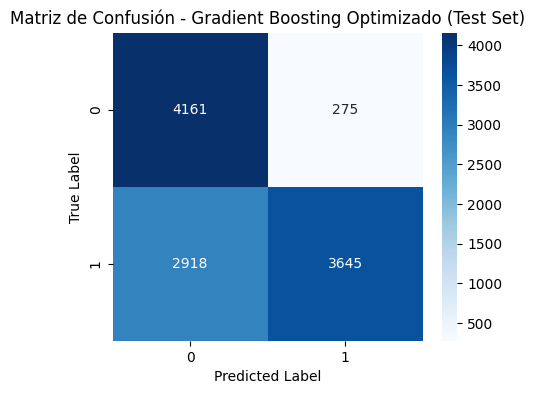

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

# Graficar la matriz
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Gradient Boosting Optimizado (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Interpretacion:

La matriz de confusión del modelo Gradient Boosting optimizado muestra que el modelo tiene una alta capacidad para identificar correctamente los pedidos que sí llegan a tiempo (alta tasa de verdaderos negativos), pero todavía existe un número considerable de pedidos retrasados que no logra detectar (falsos negativos). Esto está alineado con el recall observado para la clase de retrasos en el classification report. Estos resultados podrían mejorarse si el objetivo del negocio fuera aumentar la detección de retrasos, por ejemplo, ajustando umbrales o utilizando técnicas de balanceo.

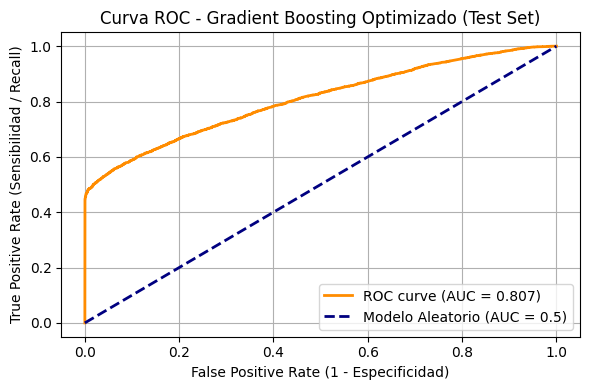

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# Graficar la ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Modelo Aleatorio (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Especificidad)')
plt.ylabel('True Positive Rate (Sensibilidad / Recall)')
plt.title('Curva ROC - Gradient Boosting Optimizado (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Interpretacion ROC

La curva ROC del modelo Gradient Boosting optimizado muestra una muy buena capacidad de discriminación, alejándose significativamente de la línea de referencia aleatoria. El área bajo la curva (AUC) obtenida fue de 0.805, lo que indica que el modelo tiene un buen equilibrio entre la tasa de verdaderos positivos (recall) y la tasa de falsos positivos. Esto significa que el modelo es capaz de distinguir correctamente entre pedidos que llegarán a tiempo y aquellos que se retrasarán en el test set.

In [152]:
import pickle

# Guardar el modelo final (puedes cambiar el nombre del archivo y el objeto del modelo)
with open('modelo_ml_f.pkl', 'wb') as file:
    pickle.dump(modelo_final, file)

print(" Modelo guardado correctamente como 'modelo_ml_f.pkl'")

 Modelo guardado correctamente como 'modelo_ml_f.pkl'
